# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 5169152/11490434 [============>.................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:09 - loss: 0.6938

  29/1875 [..............................] - ETA: 3s - loss: 0.5498   

  59/1875 [..............................] - ETA: 3s - loss: 0.4664

  79/1875 [>.............................] - ETA: 3s - loss: 0.4356

 107/1875 [>.............................] - ETA: 3s - loss: 0.4061

 141/1875 [=>............................] - ETA: 3s - loss: 0.3814

 176/1875 [=>............................] - ETA: 2s - loss: 0.3627

 205/1875 [==>...........................] - ETA: 2s - loss: 0.3503

 235/1875 [==>...........................] - ETA: 2s - loss: 0.3395

 264/1875 [===>..........................] - ETA: 2s - loss: 0.3305

 291/1875 [===>..........................] - ETA: 2s - loss: 0.3230

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3154

 350/1875 [====>.........................] - ETA: 2s - loss: 0.3092

 374/1875 [====>.........................] - ETA: 2s - loss: 0.3043

 404/1875 [=====>........................] - ETA: 2s - loss: 0.2986

 433/1875 [=====>........................] - ETA: 2s - loss: 0.2936

 463/1875 [======>.......................] - ETA: 2s - loss: 0.2889

 492/1875 [======>.......................] - ETA: 2s - loss: 0.2846

 522/1875 [=======>......................] - ETA: 2s - loss: 0.2804

 549/1875 [=======>......................] - ETA: 2s - loss: 0.2769

 579/1875 [========>.....................] - ETA: 2s - loss: 0.2733

 611/1875 [========>.....................] - ETA: 2s - loss: 0.2696

 642/1875 [=========>....................] - ETA: 2s - loss: 0.2663

 677/1875 [=========>....................] - ETA: 2s - loss: 0.2628

 709/1875 [==========>...................] - ETA: 2s - loss: 0.2597

 738/1875 [==========>...................] - ETA: 1s - loss: 0.2571

 767/1875 [===========>..................] - ETA: 1s - loss: 0.2546

 798/1875 [===========>..................] - ETA: 1s - loss: 0.2521

 830/1875 [============>.................] - ETA: 1s - loss: 0.2496

 866/1875 [============>.................] - ETA: 1s - loss: 0.2469

 896/1875 [=============>................] - ETA: 1s - loss: 0.2448

 926/1875 [=============>................] - ETA: 1s - loss: 0.2428

 953/1875 [==============>...............] - ETA: 1s - loss: 0.2410

 982/1875 [==============>...............] - ETA: 1s - loss: 0.2391

1011/1875 [===============>..............] - ETA: 1s - loss: 0.2374

1040/1875 [===============>..............] - ETA: 1s - loss: 0.2357

1065/1875 [================>.............] - ETA: 1s - loss: 0.2342

1091/1875 [================>.............] - ETA: 1s - loss: 0.2328

1121/1875 [================>.............] - ETA: 1s - loss: 0.2312

1150/1875 [=================>............] - ETA: 1s - loss: 0.2297

1179/1875 [=================>............] - ETA: 1s - loss: 0.2282

1207/1875 [==================>...........] - ETA: 1s - loss: 0.2269

1236/1875 [==================>...........] - ETA: 1s - loss: 0.2255

1265/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1297/1875 [===================>..........] - ETA: 0s - loss: 0.2227

1329/1875 [====================>.........] - ETA: 0s - loss: 0.2213

1356/1875 [====================>.........] - ETA: 0s - loss: 0.2202

1382/1875 [=====================>........] - ETA: 0s - loss: 0.2191

1409/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1439/1875 [======================>.......] - ETA: 0s - loss: 0.2168

1472/1875 [======================>.......] - ETA: 0s - loss: 0.2156

1503/1875 [=======================>......] - ETA: 0s - loss: 0.2144

1533/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1566/1875 [========================>.....] - ETA: 0s - loss: 0.2122

1595/1875 [========================>.....] - ETA: 0s - loss: 0.2111

1622/1875 [========================>.....] - ETA: 0s - loss: 0.2102

1649/1875 [=========================>....] - ETA: 0s - loss: 0.2093

1678/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1707/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1736/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1770/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1807/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1842/1875 [============================>.] - ETA: 0s - loss: 0.2034

1874/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2025


Epoch 2/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1201

  33/1875 [..............................] - ETA: 2s - loss: 0.1132

  63/1875 [>.............................] - ETA: 2s - loss: 0.1121

  92/1875 [>.............................] - ETA: 2s - loss: 0.1113

 122/1875 [>.............................] - ETA: 2s - loss: 0.1110

 155/1875 [=>............................] - ETA: 2s - loss: 0.1108

 183/1875 [=>............................] - ETA: 2s - loss: 0.1106

 214/1875 [==>...........................] - ETA: 2s - loss: 0.1104

 242/1875 [==>...........................] - ETA: 2s - loss: 0.1103

 272/1875 [===>..........................] - ETA: 2s - loss: 0.1102

 302/1875 [===>..........................] - ETA: 2s - loss: 0.1101

 333/1875 [====>.........................] - ETA: 2s - loss: 0.1100

 362/1875 [====>.........................] - ETA: 2s - loss: 0.1099

 390/1875 [=====>........................] - ETA: 2s - loss: 0.1098

 420/1875 [=====>........................] - ETA: 2s - loss: 0.1097

 449/1875 [======>.......................] - ETA: 2s - loss: 0.1096

 479/1875 [======>.......................] - ETA: 2s - loss: 0.1095

 508/1875 [=======>......................] - ETA: 2s - loss: 0.1094

 544/1875 [=======>......................] - ETA: 2s - loss: 0.1093

 565/1875 [========>.....................] - ETA: 2s - loss: 0.1092

 591/1875 [========>.....................] - ETA: 2s - loss: 0.1091

 620/1875 [========>.....................] - ETA: 2s - loss: 0.1091

 649/1875 [=========>....................] - ETA: 2s - loss: 0.1090

 679/1875 [=========>....................] - ETA: 2s - loss: 0.1089

 713/1875 [==========>...................] - ETA: 1s - loss: 0.1088

 747/1875 [==========>...................] - ETA: 1s - loss: 0.1087

 782/1875 [===========>..................] - ETA: 1s - loss: 0.1087

 810/1875 [===========>..................] - ETA: 1s - loss: 0.1086

 835/1875 [============>.................] - ETA: 1s - loss: 0.1085

 860/1875 [============>.................] - ETA: 1s - loss: 0.1085

 897/1875 [=============>................] - ETA: 1s - loss: 0.1084

 930/1875 [=============>................] - ETA: 1s - loss: 0.1083

 960/1875 [==============>...............] - ETA: 1s - loss: 0.1082

 986/1875 [==============>...............] - ETA: 1s - loss: 0.1082

1013/1875 [===============>..............] - ETA: 1s - loss: 0.1081

1042/1875 [===============>..............] - ETA: 1s - loss: 0.1080

1070/1875 [================>.............] - ETA: 1s - loss: 0.1080

1097/1875 [================>.............] - ETA: 1s - loss: 0.1079

1126/1875 [=================>............] - ETA: 1s - loss: 0.1079

1151/1875 [=================>............] - ETA: 1s - loss: 0.1078

1179/1875 [=================>............] - ETA: 1s - loss: 0.1077

1208/1875 [==================>...........] - ETA: 1s - loss: 0.1077

1235/1875 [==================>...........] - ETA: 1s - loss: 0.1076

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1076

1293/1875 [===================>..........] - ETA: 1s - loss: 0.1075

1325/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1360/1875 [====================>.........] - ETA: 0s - loss: 0.1074

1385/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1413/1875 [=====================>........] - ETA: 0s - loss: 0.1073

1442/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1472/1875 [======================>.......] - ETA: 0s - loss: 0.1072

1501/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1530/1875 [=======================>......] - ETA: 0s - loss: 0.1071

1559/1875 [=======================>......] - ETA: 0s - loss: 0.1070

1590/1875 [========================>.....] - ETA: 0s - loss: 0.1070

1626/1875 [=========================>....] - ETA: 0s - loss: 0.1069

1660/1875 [=========================>....] - ETA: 0s - loss: 0.1068

1691/1875 [==========================>...] - ETA: 0s - loss: 0.1068

1722/1875 [==========================>...] - ETA: 0s - loss: 0.1067

1753/1875 [===========================>..] - ETA: 0s - loss: 0.1067

1783/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1811/1875 [===========================>..] - ETA: 0s - loss: 0.1066

1836/1875 [============================>.] - ETA: 0s - loss: 0.1066

1870/1875 [============================>.] - ETA: 0s - loss: 0.1065

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1065


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0976

  30/1875 [..............................] - ETA: 3s - loss: 0.0978

  63/1875 [>.............................] - ETA: 2s - loss: 0.0981

  96/1875 [>.............................] - ETA: 2s - loss: 0.0984

 130/1875 [=>............................] - ETA: 2s - loss: 0.0985

 164/1875 [=>............................] - ETA: 2s - loss: 0.0987

 185/1875 [=>............................] - ETA: 2s - loss: 0.0988

 208/1875 [==>...........................] - ETA: 2s - loss: 0.0989

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0989

 256/1875 [===>..........................] - ETA: 2s - loss: 0.0990

 276/1875 [===>..........................] - ETA: 3s - loss: 0.0990

 296/1875 [===>..........................] - ETA: 3s - loss: 0.0990

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0991

 341/1875 [====>.........................] - ETA: 3s - loss: 0.0991

 360/1875 [====>.........................] - ETA: 3s - loss: 0.0991

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0991

 397/1875 [=====>........................] - ETA: 3s - loss: 0.0991

 420/1875 [=====>........................] - ETA: 3s - loss: 0.0991

 445/1875 [======>.......................] - ETA: 3s - loss: 0.0991

 470/1875 [======>.......................] - ETA: 2s - loss: 0.0991

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0991

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0991

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0991

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0991

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0990

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0990

 673/1875 [=========>....................] - ETA: 2s - loss: 0.0990

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0990

 723/1875 [==========>...................] - ETA: 2s - loss: 0.0990

 750/1875 [===========>..................] - ETA: 2s - loss: 0.0990

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0990

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0990

 825/1875 [============>.................] - ETA: 2s - loss: 0.0989

 853/1875 [============>.................] - ETA: 2s - loss: 0.0989

 879/1875 [=============>................] - ETA: 2s - loss: 0.0989

 905/1875 [=============>................] - ETA: 1s - loss: 0.0989

 926/1875 [=============>................] - ETA: 1s - loss: 0.0989

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0989

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0989

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0989

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0989

1055/1875 [===============>..............] - ETA: 1s - loss: 0.0989

1081/1875 [================>.............] - ETA: 1s - loss: 0.0989

1104/1875 [================>.............] - ETA: 1s - loss: 0.0989

1134/1875 [=================>............] - ETA: 1s - loss: 0.0988

1166/1875 [=================>............] - ETA: 1s - loss: 0.0988

1188/1875 [==================>...........] - ETA: 1s - loss: 0.0988

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0988

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0988

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0988

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0988

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0988

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0988

1368/1875 [====================>.........] - ETA: 1s - loss: 0.0988

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0988

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0988

1445/1875 [======================>.......] - ETA: 0s - loss: 0.0987

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0987

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0987

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0987

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0987

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0987

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0987

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0987

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0987

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0987

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0987

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0987

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0986

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0986

1816/1875 [============================>.] - ETA: 0s - loss: 0.0986

1845/1875 [============================>.] - ETA: 0s - loss: 0.0986

1874/1875 [============================>.] - ETA: 0s - loss: 0.0986

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0986


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1076

  28/1875 [..............................] - ETA: 3s - loss: 0.0983

  58/1875 [..............................] - ETA: 3s - loss: 0.0980

  80/1875 [>.............................] - ETA: 3s - loss: 0.0978

 106/1875 [>.............................] - ETA: 3s - loss: 0.0976

 134/1875 [=>............................] - ETA: 3s - loss: 0.0974

 159/1875 [=>............................] - ETA: 3s - loss: 0.0973

 185/1875 [=>............................] - ETA: 3s - loss: 0.0972

 210/1875 [==>...........................] - ETA: 3s - loss: 0.0972

 231/1875 [==>...........................] - ETA: 3s - loss: 0.0971

 256/1875 [===>..........................] - ETA: 3s - loss: 0.0971

 282/1875 [===>..........................] - ETA: 3s - loss: 0.0970

 308/1875 [===>..........................] - ETA: 3s - loss: 0.0970

 332/1875 [====>.........................] - ETA: 3s - loss: 0.0970

 358/1875 [====>.........................] - ETA: 3s - loss: 0.0969

 384/1875 [=====>........................] - ETA: 3s - loss: 0.0969

 406/1875 [=====>........................] - ETA: 2s - loss: 0.0969

 433/1875 [=====>........................] - ETA: 2s - loss: 0.0969

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0969

 482/1875 [======>.......................] - ETA: 2s - loss: 0.0969

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0969

 537/1875 [=======>......................] - ETA: 2s - loss: 0.0969

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0969

 594/1875 [========>.....................] - ETA: 2s - loss: 0.0969

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 655/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 685/1875 [=========>....................] - ETA: 2s - loss: 0.0969

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0969

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0969

 775/1875 [===========>..................] - ETA: 2s - loss: 0.0969

 804/1875 [===========>..................] - ETA: 2s - loss: 0.0969

 835/1875 [============>.................] - ETA: 1s - loss: 0.0969

 863/1875 [============>.................] - ETA: 1s - loss: 0.0969

 886/1875 [=============>................] - ETA: 1s - loss: 0.0969

 916/1875 [=============>................] - ETA: 1s - loss: 0.0969

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0969

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0969

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0969

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0969

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0969

1068/1875 [================>.............] - ETA: 1s - loss: 0.0969

1090/1875 [================>.............] - ETA: 1s - loss: 0.0969

1113/1875 [================>.............] - ETA: 1s - loss: 0.0969

1139/1875 [=================>............] - ETA: 1s - loss: 0.0969

1162/1875 [=================>............] - ETA: 1s - loss: 0.0969

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0969

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0969

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0969

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0969

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0969

1310/1875 [===================>..........] - ETA: 1s - loss: 0.0969

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0969

1356/1875 [====================>.........] - ETA: 1s - loss: 0.0969

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0969

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0969

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0969

1452/1875 [======================>.......] - ETA: 0s - loss: 0.0969

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0969

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0968

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0968

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0968

1578/1875 [========================>.....] - ETA: 0s - loss: 0.0968

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0968

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0968

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0968

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0968

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0968

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0968

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0968

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0968

1795/1875 [===========================>..] - ETA: 0s - loss: 0.0968

1818/1875 [============================>.] - ETA: 0s - loss: 0.0968

1845/1875 [============================>.] - ETA: 0s - loss: 0.0968

1872/1875 [============================>.] - ETA: 0s - loss: 0.0968

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0968


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0977

  27/1875 [..............................] - ETA: 3s - loss: 0.0965

  50/1875 [..............................] - ETA: 3s - loss: 0.0963

  70/1875 [>.............................] - ETA: 4s - loss: 0.0962

  97/1875 [>.............................] - ETA: 3s - loss: 0.0960

 119/1875 [>.............................] - ETA: 3s - loss: 0.0959

 148/1875 [=>............................] - ETA: 3s - loss: 0.0959

 173/1875 [=>............................] - ETA: 3s - loss: 0.0958

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 244/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 296/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 324/1875 [====>.........................] - ETA: 3s - loss: 0.0958

 353/1875 [====>.........................] - ETA: 3s - loss: 0.0958

 381/1875 [=====>........................] - ETA: 3s - loss: 0.0958

 410/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 573/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 642/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 666/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 691/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 741/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 763/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 789/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 815/1875 [============>.................] - ETA: 2s - loss: 0.0958

 844/1875 [============>.................] - ETA: 2s - loss: 0.0958

 870/1875 [============>.................] - ETA: 2s - loss: 0.0958

 892/1875 [=============>................] - ETA: 1s - loss: 0.0958

 916/1875 [=============>................] - ETA: 1s - loss: 0.0958

 945/1875 [==============>...............] - ETA: 1s - loss: 0.0958

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1000/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1057/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1087/1875 [================>.............] - ETA: 1s - loss: 0.0958

1116/1875 [================>.............] - ETA: 1s - loss: 0.0958

1145/1875 [=================>............] - ETA: 1s - loss: 0.0958

1172/1875 [=================>............] - ETA: 1s - loss: 0.0958

1201/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1228/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0958

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0958

1342/1875 [====================>.........] - ETA: 1s - loss: 0.0958

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1486/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0959

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1705/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1829/1875 [============================>.] - ETA: 0s - loss: 0.0959

1855/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0959


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

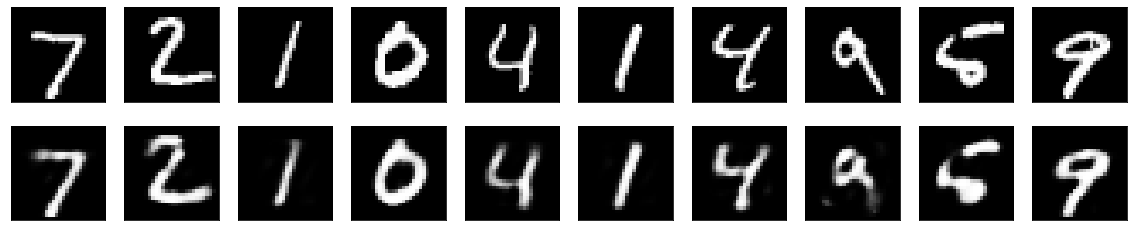

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
